<a href="https://colab.research.google.com/github/savula13/ProjectsInMLandAI/blob/main/assign5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
import PIL
import PIL.Image as Image
import pathlib

# Keras Libraries
import keras
import time
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling, Resizing, RandomFlip, RandomRotation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dir = os.listdir('../content/drive/MyDrive/brain_tumor')
print(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['brain_tumor', '__MACOSX']


# Exploratory Data Analaysis and Preprocessing

For Task 1, I used a dataset of Brain Tumor MRI images for the Convolutional Neural Network. The dataset has 4 classifcations of images, pituitary tumors, glioma tumors, meningioma tumors, no tumors. I chose this task because MRI images can be hard to decipher for people who are not medical experts. Applying a CNN to these images is powerful and can help diagnoses.

Link to dataset - https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [3]:
#reading training and test folders
train_folder= 'brain_tumor/Training'
test_folder = 'brain_tumor/Testing'

classes = os.listdir(train_folder)
training_classes = []
for c in classes:
    training_classes.append(train_folder + '/' + c)

classes = os.listdir(test_folder)
test_classes = []
for c in classes:
    test_classes.append(test_folder + '/' + c)

training_classes


['brain_tumor/Training/glioma',
 'brain_tumor/Training/pituitary',
 'brain_tumor/Training/meningioma',
 'brain_tumor/Training/notumor']

Below, an image from each class is visualized

glioma MRI Tr-gl_0039.jpg
pituitary MRI Tr-pi_0364.jpg
meningioma MRI Tr-me_0946.jpg
notumor MRI Tr-no_1017.jpg


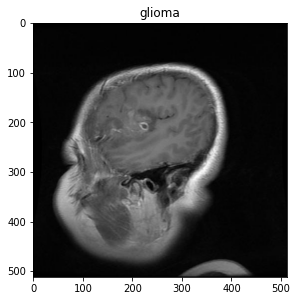

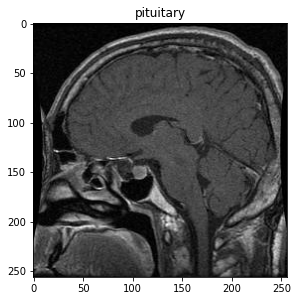

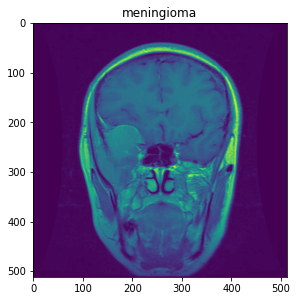

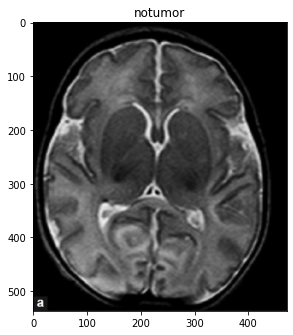

In [4]:
#visualizing images from each class in dataset
for i in range(len(training_classes)):
    c = training_classes[i]
    rand = np.random.randint(0,len(os.listdir(c)))
    pic = os.listdir(c)[rand]
    print("{} MRI".format(classes[i]), pic)

    norm_load = Image.open(c + '/' + pic)

    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_load)
    a1.set_title("{}".format(classes[i]))


# Task 1

## Part 1 - CNN Base Model

Once the images have been loaded, training and validation datasets are created with an 80-20 split and abatch size of 32.

In [22]:
#setting batch size and size of loaded images
batch_size = 32
img_height = 180
img_width = 180

#setting training folder to be the data directory for validation and testing
data_dir = pathlib.Path(train_folder)
data_dir

#test folder dir
test_dir = pathlib.Path(test_folder)


In [8]:
#creating training set with 20% validation split
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [9]:
#creating validation data from training data
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [24]:
test_ds = keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width))

Found 1311 files belonging to 4 classes.


In [10]:
#Class names from training dataset
class_names = train_ds.class_names
print(class_names)


['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
#Ensuring images are still of the right shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


In [12]:
#caching images from disk when training for better peformance and efficiency
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


The CNN base model is created with a stack of 2d-Convolutions and Max Pooling (3 each). In the first step of the model, the images are rescaled since each pixel has a value of 255 before rescaling. The model is then flattened and a final Dense outut layer has an output with the total number of classes in the dataset (4).

This specific architecture was chosen because the literature shows that there are minimal improvements after addind 4 layers. The max pooling layers are stacked in between to increase efficiency to pool the highest values in a region for the model to learn patterns in the data quickly. Before the data is fed into the network, the pixel values are rescaled from 0-255 to 0-1 which is recommended practice for neural networks as this increases peformance and efficiency of the model.

In [13]:
num_classes = 4

cnn = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32,(7,7), input_shape=(180, 180, 3), padding='same', activation='relu'),  
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])


The model uses Sparse Categorical Crossentrooy as its loss function because it has more than 2 classes. It uses an Adam optimizer which is standard for many CNNs and accuracy as its metric, regarding the accuracy of the prediction to the actual class.

In [14]:
cnn.compile(
  optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [15]:
#Fitting the model for 3 epochs with the validation dataset
history = cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)


Epoch 1/3
143/143 [==============================] - 323s 2s/step - loss: 0.6968 - accuracy: 0.7201 - val_loss: 0.4789 - val_accuracy: 0.8415
Epoch 2/3
143/143 [==============================] - 319s 2s/step - loss: 0.3527 - accuracy: 0.8718 - val_loss: 0.2767 - val_accuracy: 0.9046
Epoch 3/3
143/143 [==============================] - 309s 2s/step - loss: 0.2067 - accuracy: 0.9243 - val_loss: 0.2466 - val_accuracy: 0.9151


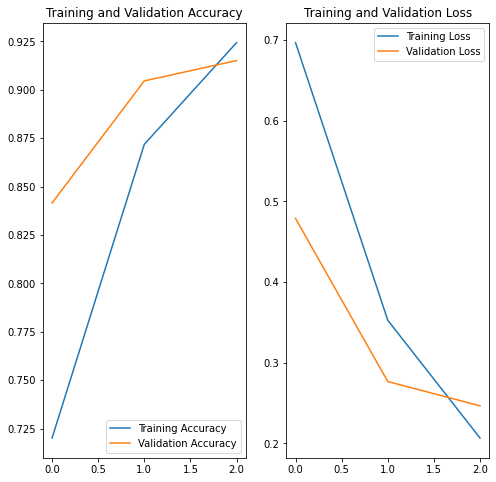

In [26]:
#function to generate evaluation plots of accuracy and loss for training and validation
def eval_plots(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


eval_plots(history, 3)


In [25]:
print('\nTest Accuracy:       {}'.format(cnn.evaluate(test_ds, steps = len(test_ds))[1]*100))

41/41 [==============================] - 26s 598ms/step - loss: 0.2659 - accuracy: 0.9016

Test Accuracy:       90.16018509864807


As seen in the plots above, the training and validation accuracy mostly improved as the CNN was trained for additional epochs. The final validation accuracy was 0.9011 and the final training accuracy was .9416, which is a big improvement over the training accuracy in the 1st epoch which was .6726. The high validation accuracy means that the model is not overfitting and it can generalize to data. 

Also, while the loss is not ideally low, as the CNN trained, both the validation and training loss decreased. This means that the model was learning well. If the model was run for more epochs, the loss may have been able to decrease to below 0.1.

Also, with the test dataset, the accuraccy was .9016 which is very accurate for testing the model on unseen data, so the CNN base model has great performance.

## Part 2 - Transfer Learning

In [17]:
def create_model(input_shape, n_classes):

    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    for layer in conv_base.layers:
        layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer= 'adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [18]:
input_shape = (180, 180, 3)

n_steps = len(train_ds) // 32
n_val_steps = len(val_ds) // 32
n_classes = 4

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes)


58889256/58889256 [==============================] - 1s 0us/step


In [19]:
vgg_history = vgg_model.fit(train_ds, steps_per_epoch = n_steps, epochs = 3, validation_data = val_ds, validation_steps = n_val_steps)

Epoch 1/3
4/4 [==============================] - 60s 16s/step - loss: 205.5076 - accuracy: 0.2578 - val_loss: 58.7450 - val_accuracy: 0.4375
Epoch 2/3
4/4 [==============================] - 53s 14s/step - loss: 36.0496 - accuracy: 0.4844 - val_loss: 18.1093 - val_accuracy: 0.5938
Epoch 3/3
4/4 [==============================] - 59s 16s/step - loss: 15.1178 - accuracy: 0.5859 - val_loss: 5.1369 - val_accuracy: 0.7188


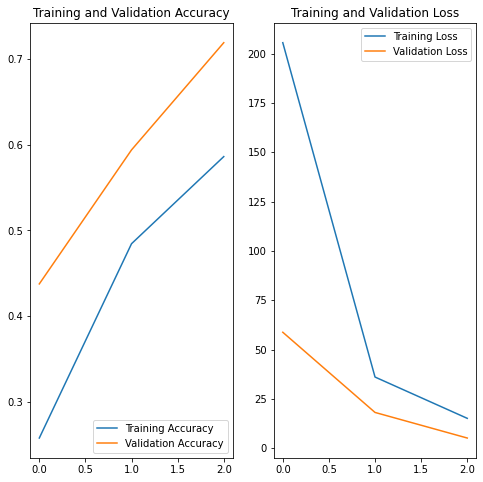

In [20]:
eval_plots(vgg_history, 3)

The VGG16 model achieved a training accuracy of .5859 and a validation accuracy of .718. While the validation accuracy is high, the overall accuracy is much lower than the baseline CNN model. Furthermore, although the losses decreased with each epoch, they are considerably high which indicated the vgg16 having poor performance.

One factor could be that the vgg16 is pretrained on imagenet and the learned weights were frozen. Imagenet does not contain MRI images, or MRI images are not a large subset of the Imagenet dataset, so it follows that the learned model for vgg16 does not perform well with MRI images.

In [27]:
print('\nVGG16 Test Accuracy:       {}'.format(vgg_model.evaluate(test_ds, steps = len(test_ds))[1]*100))

41/41 [==============================] - 441s 11s/step - loss: 6.4689 - accuracy: 0.7498

VGG16 Test Accuracy:       74.98093247413635


The test accuracy of the VGG16 on the test set is ~ 75% which is good, but not as good as the accuracy of the base CNN model. 

## Part 3 - Data Augmentation

Data augmentation methods can be applied to the training data to prevent overfitting and to help the model generalize. The same model artchitecture is used as before, however different augmentations are applied to the images before it is fed into the layers of the network:

RandomFlip - image is randomly flipped either vertically or horizontally

RandomRotation - image is randomly rotated by a factor

RandomTranslation - random translations are applied (shifting horizontally and vertically)

Epoch 1/3
143/143 [==============================] - 331s 2s/step - loss: 0.9154 - accuracy: 0.6195 - val_loss: 0.6620 - val_accuracy: 0.7557
Epoch 2/3
143/143 [==============================] - 326s 2s/step - loss: 0.6573 - accuracy: 0.7435 - val_loss: 0.6695 - val_accuracy: 0.7548
Epoch 3/3
143/143 [==============================] - 320s 2s/step - loss: 0.5736 - accuracy: 0.7840 - val_loss: 0.5418 - val_accuracy: 0.8161


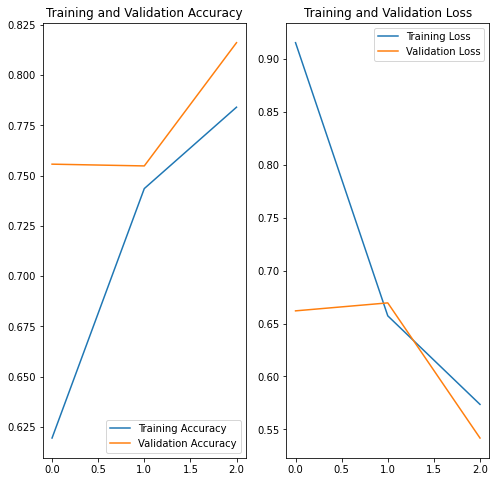

In [29]:
resize_and_rescale = tf.keras.Sequential([
  Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])


aug_model = keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  keras.layers.Conv2D(32,(7,7), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same', activation='relu'),  
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])


aug_model.compile(
  optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

aug_history = aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

eval_plots(aug_history, 3)
  


The Data Augmented CNN model had respectable performance as seen in the accuracy and loss plots. Over the 3 epochs, the training and validation accuracy increased, with a final validation accuracy of .81 and a training accuracy of .78. While this is better than the VGG16 model it is not as good as the baseline CNN model.

The loss for the training and validation also decreased over the epochs for a final training loss of .57 and a final validation loss of .54. This is much better than the VGG16 model, but not as good as the baseline CNN model.

One reason for the slightly worse performance could be that the specific augmentations which were applied helped the model generalize too much, so it underfit to the data. Also, it was ran for 3 epochs with consistent improvements, so training the model for more epochs could lead to improved performance.

In [30]:
print('\nAugmented Model Test Accuracy:       {}'.format(aug_model.evaluate(test_ds, steps = len(test_ds))[1]*100))

41/41 [==============================] - 27s 630ms/step - loss: 0.6802 - accuracy: 0.7536

Augmented Model Test Accuracy:       75.36231875419617


The Data Augmented model has a 75% accuracy when evaluated on the test set which is similar to the VGG16 test accuracy and is worse than the baseline CNN accuracy. This could be due to the fact that the baseline CNN had a larger stack and achieved better performance from that and the non-augmented input data.

# Task 2
# Part 1 - Variational Auto Encoder

In [ ]:
#Imports
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Loading the Fashion MNIST dataset which is a dataset provided from Keras (different than the MNIST dataset used in the example). This dataset contans 60,000 of 28x28 grayscale images from 10 fashion categories with a test set of 10,000 images.

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
train_images.shape

(60000, 28, 28)

Preprocessing for the images where the pixels are rescaled to be from a range of 0-1 (previously 0-255). 

In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


In [ ]:
#setting variables for training size, batch size, and test size for creating batched datasets
train_size = 60000
batch_size = 32
test_size = 10000


Creating Batched Datasets for input into Convolutional Variational Autoencoder

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))


Convolutional Variational Autoencoder Architecture - used from https://www.tensorflow.org/tutorials/generative/cvae

This architecture uses 2 small ConvNets for the encoder and decoder networks.

In the Encoder network, an observation is taken in as input and the output is a conditional diagonal Gaussian distributiuon of the latent representation. It uses 2 convolutional layers followed by a fully connected layer.

In the Decoder network, it defines the conditional distribution of the input and outputs the parameters for a conditional distribution. It uses a fully connected layer followed by 3 convolution transose layers.

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


The loss function is defined by maximizing evidence lower bound (ELBO) on marginal log-likelihood, which is imlemented by optimizing the single sample Monte Carlo estimate.

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


For training, at each iteration through the dataset, the image is passed to the encoder to get parameters for the probability distribution. The reparameterized samples are passed to the decoder to get the raw generative distribtiuon to generate images.

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


Images are generated by sampling and converting the latent vectors from the Gaussian distribution to the data of the observation.

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]


Below, a sample of images are generated after passing through the encoder decoder architecture. You can clearly see the distinctions between different articles of cloting (pants, shirts, etc.).

Epoch: 10, Test set ELBO: -193.3994140625, time elapse for current epoch: 47.23273968696594


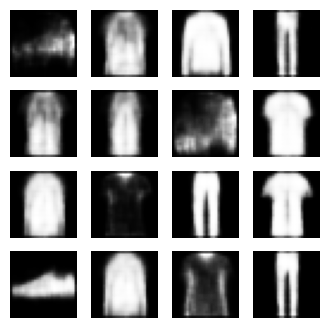

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


## Task 2 Part 2 - Convolutional Generative Adversarial Network (GAN)

In [54]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [55]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [56]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


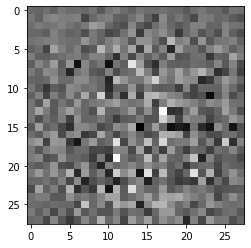

In [57]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [58]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [59]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00110635]], shape=(1, 1), dtype=float32)


In [60]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [62]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [63]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [64]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [65]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [66]:
train(train_ds, EPOCHS)

ValueError: ignored